# Libraries and Helper Functions

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def model_evaluation(y, predictions, label):
    class_labels = ['Not Readmitted', 'Readmitted']
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision = precision_score(y, predictions)
    print('{0} Precision: {1:.4f}'.format(label, precision))
    #calculate recall
    recall = recall_score(y, predictions)
    print('{0} Recall: {1:.4f}'.format(label, recall))
    #calculate f1
    f1 = f1_score(y, predictions)
    print('{0} F1: {1:.4f}'.format(label, f1))    
    cm = confusion_matrix(y, predictions)
    df_cm = np.transpose( np.transpose(cm) / cm.astype(np.float).sum(axis=1) )
    df_cm = pd.DataFrame(df_cm, index = class_labels, columns = class_labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return [accuracy, precision, recall, f1]

In [13]:
def plot_roc(y, predictions):
    
    roc_aucs = []
    
    # Compute fpr, tpr, thresholds and roc auc
    for model_name, prediction in predictions.iteritems():
        
        fpr, tpr, thresholds = roc_curve(y, prediction)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.show()

In [45]:
def plot_cost_effectiveness(y, probabilities):
    C_INTERVENTION = 1300 
    C_READMISSION = 13679
    P_REDUCTION = 1.0
    P_ALLPATIENT_READMISSION = y.sum() * 1.0 / y.shape[0]
    costs = []
    for i in xrange(0, 100, 5):
        i = i * 1.0 / 100.0
        predictions = probabilities > i
        total_cost = 0
        for actual, predicted in zip(y, predictions):
            c_intervention = C_INTERVENTION if predicted else 0
            p_reduction = P_REDUCTION if predicted and actual else 0
            total_cost += (c_intervention + P_ALLPATIENT_READMISSION * (1.0 - p_reduction) * C_READMISSION)
        costs.append(total_cost)
    
    print('Minimum Cost: ${0:,.0f}'.format(min(costs)))
    return costs
    

In [15]:
def get_feature_importance(feature_importance, X_train):
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    predictors = X_train.columns
    predictors = [predictors[i] for i in indices]
    predictors_index = range(1, len(predictors) + 1)
    num_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.bar(predictors_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(predictors_index[:num_features], predictors[:num_features], rotation = 'vertical')
    plt.show()

# Load and Split Dataset

In [16]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train = train_df.drop('READMISSION', axis = 1)
y_train = train_df['READMISSION']
X_test = test_df.drop('READMISSION', axis = 1)
y_test = test_df['READMISSION']

# Blank Guess Models

### No Readmission

In [41]:
noreadmission_train_predictions_class = y_train.apply(lambda x: False)
noreadmission_train_predictions_probabilities = y_train.apply(lambda x: 0.0)
noreadmission_test_predictions_class = y_test.apply(lambda x: False)
noreadmission_test_predictions_probabilities = y_test.apply(lambda x: 0.0)

noreadmission - Train Accuracy: 0.8235
noreadmission - Train Precision: 0.0000
noreadmission - Train Recall: 0.0000
noreadmission - Train F1: 0.0000


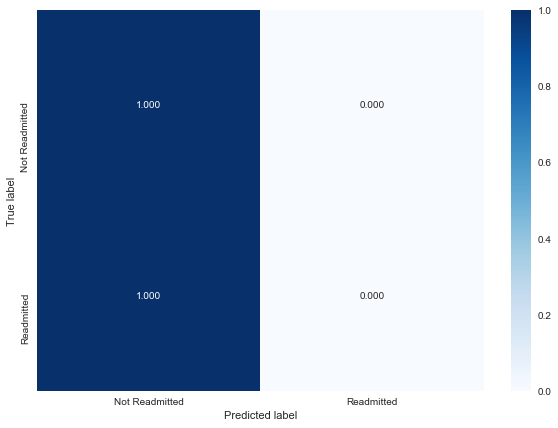

noreadmission - Test Accuracy: 0.8175
noreadmission - Test Precision: 0.0000
noreadmission - Test Recall: 0.0000
noreadmission - Test F1: 0.0000


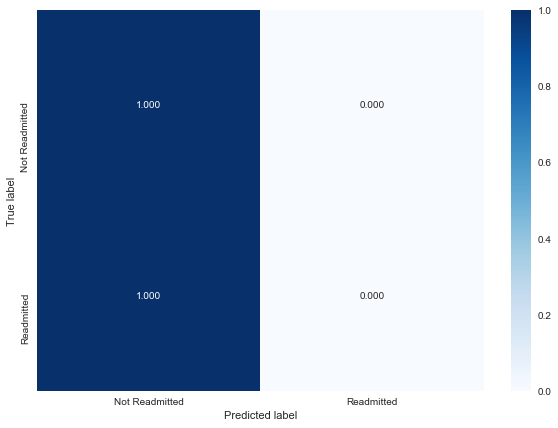

In [53]:
noreadmission_train_scores = model_evaluation(y_train, noreadmission_train_predictions_class, 'noreadmission - Train')
noreadmission_test_scores = model_evaluation(y_test, noreadmission_test_predictions_class, 'noreadmission - Test')

In [52]:
noreadmission_cost_effectiveness = plot_cost_effectiveness(y_test, noreadmission_test_predictions_probabilities)

Minimum Cost: $21,024,623


### Readmission

In [20]:
readmission_train_predictions_class = y_train.apply(lambda x: True)
readmission_train_predictions_probabilities = y_train.apply(lambda x: 1.0)
readmission_test_predictions_class = y_test.apply(lambda x: True)
readmission_test_predictions_probabilities = y_test.apply(lambda x: 1.0)

readmission - Train Accuracy: 0.1765
readmission - Train Precision: 0.1765
readmission - Train Recall: 1.0000
readmission - Train F1: 0.3000


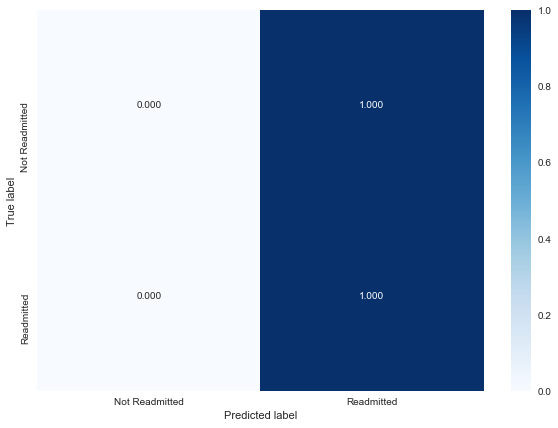

readmission - Test Accuracy: 0.1825
readmission - Test Precision: 0.1825
readmission - Test Recall: 1.0000
readmission - Test F1: 0.3086


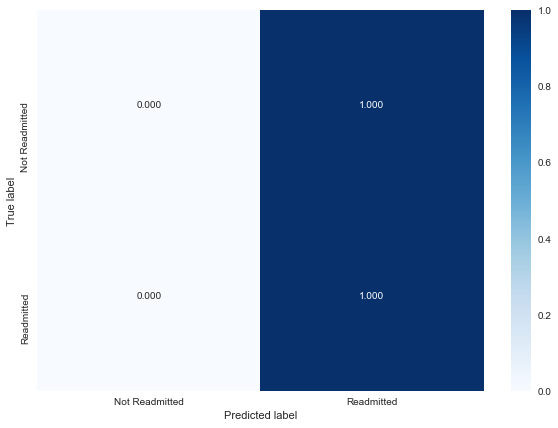

In [21]:
readmission_train_scores = model_evaluation(y_train, readmission_train_predictions_class, 'readmission - Train')
readmission_test_scores = model_evaluation(y_test, readmission_test_predictions_class, 'readmission - Test')

In [51]:
readmission_cost_effectiveness = plot_cost_effectiveness(y_test, readmission_test_predictions_probabilities)

Minimum Cost: $28,138,022


# Logistic Regression L1 Regularization

In [44]:
parameters_to_tune = {'penalty':['l1'], 'C':[10.0**i for i in range(-7,8)], 'class_weight':['balanced'],
                     'random_state':[42], 'n_jobs': [-1]}
logregl1 = LogisticRegression()
logregl1_cv = GridSearchCV(logregl1, parameters_to_tune, scoring = "precision", cv = 5, verbose = 1)
logregl1_cv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  6.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0], 'random_state': [42], 'n_jobs': [-1], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=1)

In [46]:
logregl1_best = logregl1_cv.best_estimator_
logregl1_train_predictions_class = logregl1_best.predict(X_train)
logregl1_train_predictions_probabilities = logregl1_best.predict_proba(X_train)
logregl1_test_predictions_class = logregl1_best.predict(X_test)
logregl1_test_predictions_probabilities = logregl1_best.predict_proba(X_test)

logregl1 - Train Accuracy: 0.6153
logregl1 - Train Precision: 0.2851
logregl1 - Train Recall: 0.7827
logregl1 - Train F1: 0.4180


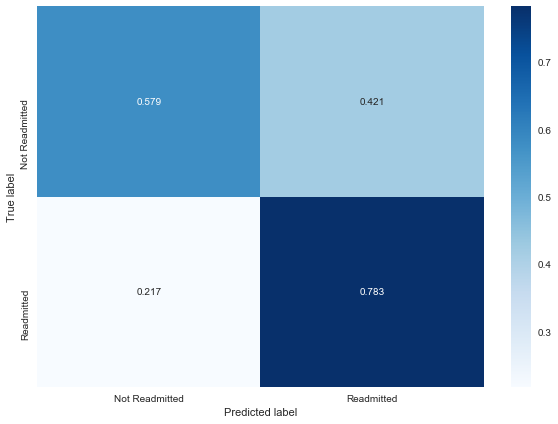

logregl1 - Test Accuracy: 0.6082
logregl1 - Test Precision: 0.2898
logregl1 - Test Recall: 0.7905
logregl1 - Test F1: 0.4241


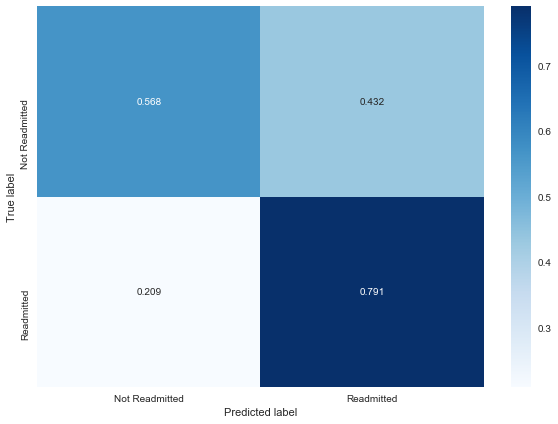

In [47]:
logregl1_train_scores = model_evaluation(y_train, logregl1_train_predictions_class, 'logregl1 - Train')
logregl1_test_scores = model_evaluation(y_test, logregl1_test_predictions_class, 'logregl1 - Test')

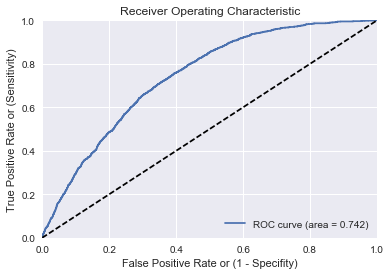

In [48]:
roc_models = {'logregl1':logregl1_test_predictions_probabilities[:, 1]}
logregl1_roc_auc = plot_roc(y_test, roc_models)

In [49]:
logregl1_cost_effectiveness = plot_cost_effectiveness(y_test, logregl1_test_predictions_probabilities[:, 1])

Minimum Cost: $21,011,205


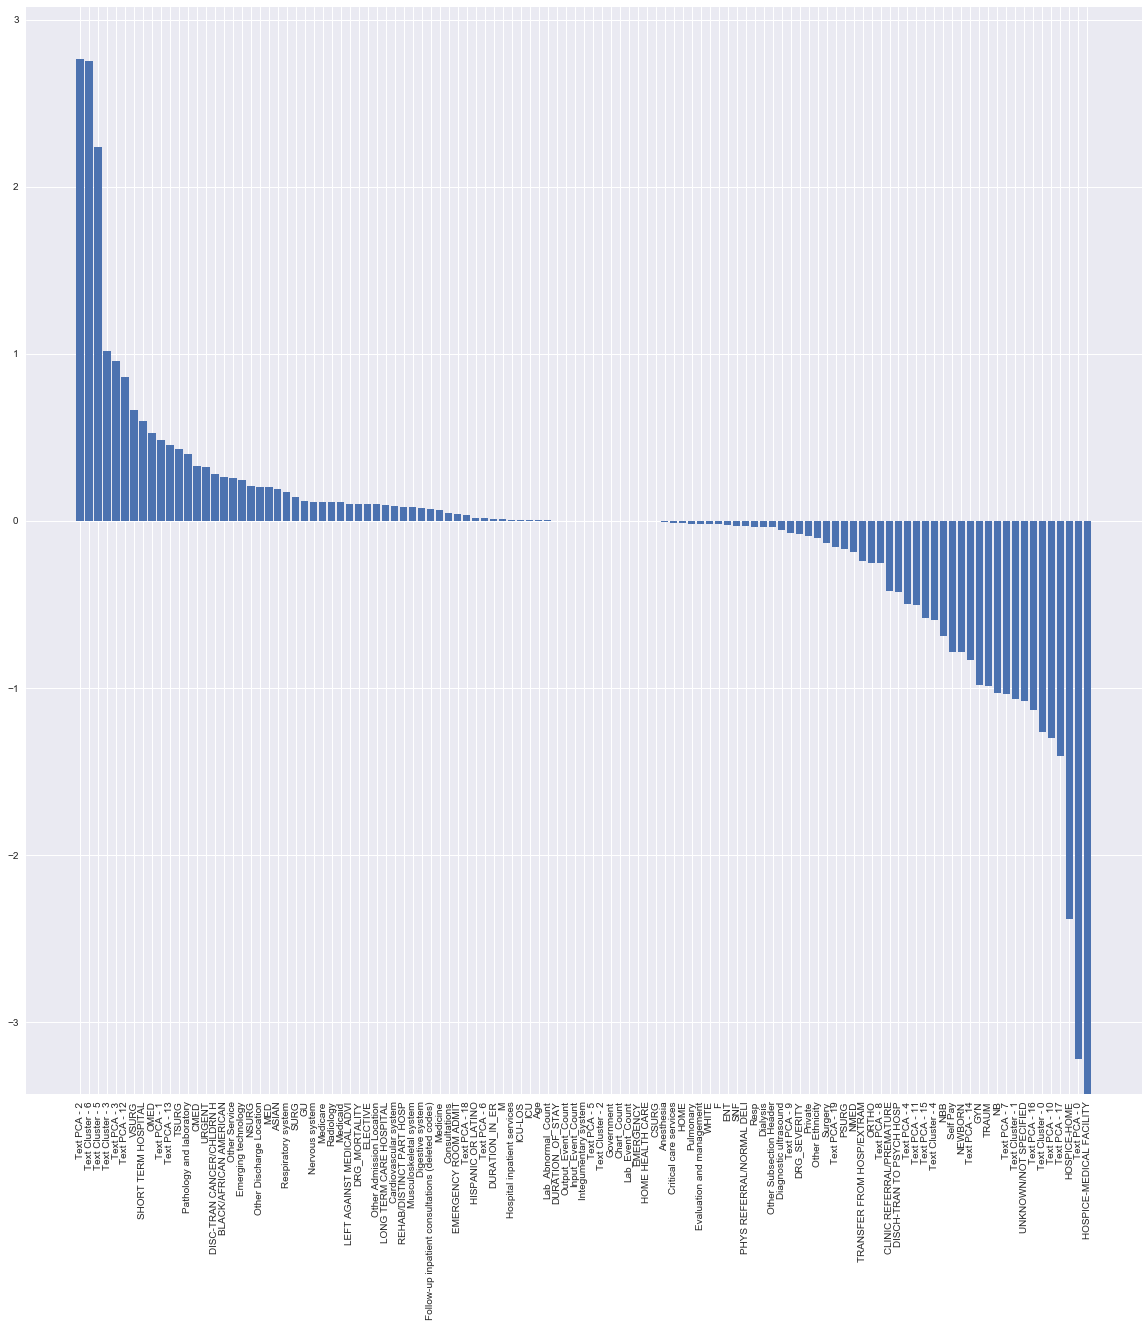

In [50]:
get_feature_importance(logregl1_best.coef_[0], X_train)

# Random Forest

# XGBoost

# SVM

 # Ensemble